<a href="https://colab.research.google.com/github/Douglas5040/Redes-Neurais-USP/blob/main/Projeto_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importando bibliotecas

In [ ]:
import tensorflow as tf

from keras.applications import MobileNetV2
from keras.preprocessing.image import ImageDataGenerator, array_to_img
from keras.models import Sequential, Model
from keras.layers import Conv2D, GlobalAveragePooling2D
from keras.layers import Activation, Dropout, Flatten, Dense
from keras import backend as K
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
import sys

# Pré processamento

Baixando dataset do KERAS, em um diretorio temporario

In [ ]:
_URL = 'https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip'
zip_dir = tf.keras.utils.get_file('cats_and_dogs_filterted.zip', origin=_URL, extract=True)

68608000/68606236 [==============================] - 1s 0us/step


Estrutura da pasta contendo bases de TESTES e AVALIAÇAO, e subpastas com os rotulos Cats e Dogs
<pre style="font-size: 10.0pt; font-family: Arial; line-height: 2; letter-spacing: 1.0pt;" >
<b>cats_and_dogs_filtered</b>
|__ <b>train</b>
    |______ <b>cats</b>: [cat.0.jpg, cat.1.jpg, cat.2.jpg ...]
    |______ <b>dogs</b>: [dog.0.jpg, dog.1.jpg, dog.2.jpg ...]
|__ <b>validation</b>
    |______ <b>cats</b>: [cat.2000.jpg, cat.2001.jpg, cat.2002.jpg ...]
    |______ <b>dogs</b>: [dog.2000.jpg, dog.2001.jpg, dog.2002.jpg ...]
</pre>

Especificando tamanho do dataSet completo e setando variaveis com os nomes e caminhos das pastas

In [ ]:
base_dir = os.path.join(os.path.dirname(zip_dir), 'cats_and_dogs_filtered')
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')

train_cats_dir = os.path.join(train_dir, 'cats')  # directory with our training cat pictures
train_dogs_dir = os.path.join(train_dir, 'dogs')  # directory with our training dog pictures
validation_cats_dir = os.path.join(validation_dir, 'cats')  # directory with our validation cat pictures
validation_dogs_dir = os.path.join(validation_dir, 'dogs')

num_cats_tr = len(os.listdir(train_cats_dir))
num_dogs_tr = len(os.listdir(train_dogs_dir))

num_cats_val = len(os.listdir(validation_cats_dir))
num_dogs_val = len(os.listdir(validation_dogs_dir))

total_train = num_cats_tr + num_dogs_tr
total_val = num_cats_val + num_dogs_val

print('total training cat images:', num_cats_tr)
print('total training dog images:', num_dogs_tr)

print('total validation cat images:', num_cats_val)
print('total validation dog images:', num_dogs_val)
print("--")
print("Total training images:", total_train)
print("Total validation images:", total_val)

total training cat images: 1000
total training dog images: 1000
total validation cat images: 500
total validation dog images: 500
--
Total training images: 2000
Total validation images: 1000


Setando parametros

In [ ]:
BATCH_SIZE = 32  # Number of training examples to process before updating our models variables
img_width, img_height = 160, 160  # Our training data consists of images with width of 160 pixels and height of 160 pixels
nb_train_samples = 2000
nb_validation_samples = 1000
epochs = 20

# Processamento do dataset

Percorrendo a estrutura do dataset (pastas) de trein e val e setando y (rotulos) de acordo com as subpastas e x de acordos com as imagens das subpastas

In [ ]:
# this is the augmentation configuration we will use for training
train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True)

# this is the augmentation configuration we will use for testing:
# only rescaling
test_datagen = ImageDataGenerator(rescale=1. / 255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_width, img_height),
    batch_size=BATCH_SIZE,
    #color_mode='grayscale',
    class_mode='binary')

validation_generator = test_datagen.flow_from_directory(
    validation_dir,
    target_size=(img_width, img_height),
    batch_size=BATCH_SIZE,
    #color_mode='grayscale',
    class_mode='binary')


Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


# Exibindo algumas fotos do data set

Escolhendo imagens do dataset

In [ ]:
train_cat_fnames = os.listdir(train_cats_dir)
print(train_cat_fnames[:10])

train_dog_fnames = os.listdir(train_dogs_dir)
train_dog_fnames.sort()
print(train_dog_fnames[:10])



['cat.337.jpg', 'cat.103.jpg', 'cat.765.jpg', 'cat.458.jpg', 'cat.111.jpg', 'cat.640.jpg', 'cat.865.jpg', 'cat.320.jpg', 'cat.70.jpg', 'cat.121.jpg']
['dog.0.jpg', 'dog.1.jpg', 'dog.10.jpg', 'dog.100.jpg', 'dog.101.jpg', 'dog.102.jpg', 'dog.103.jpg', 'dog.104.jpg', 'dog.105.jpg', 'dog.106.jpg']


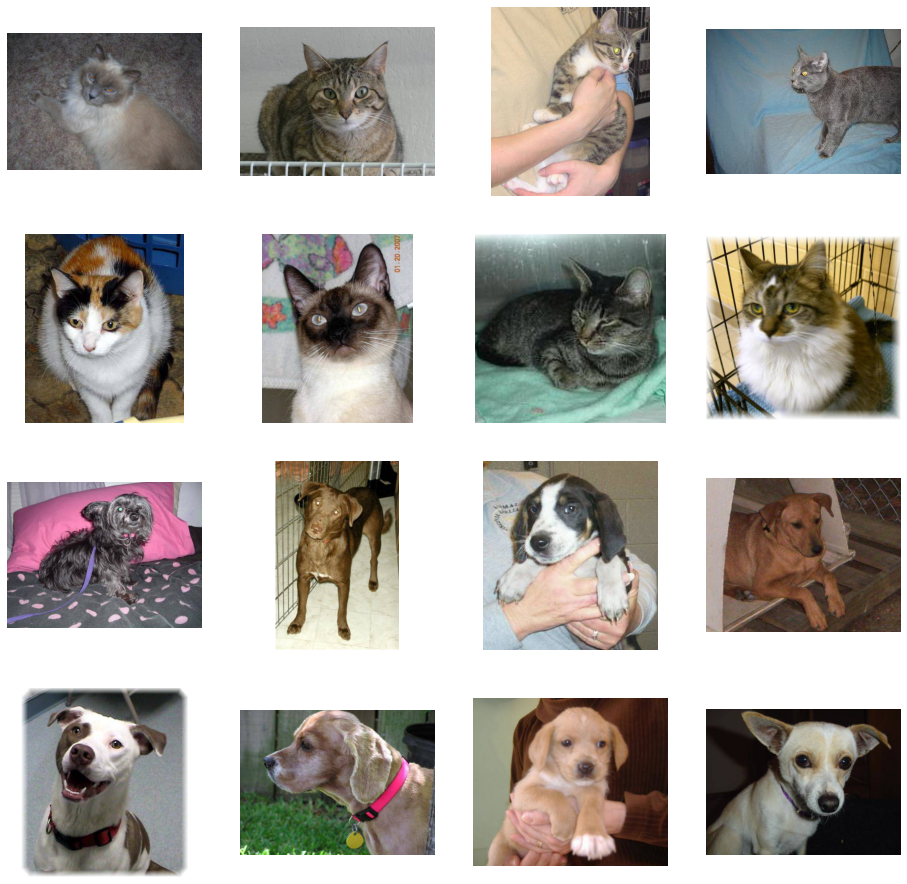

In [ ]:
%matplotlib inline

# Parameters for our graph; we'll output images in a 4x4 configuration
nrows = 4
ncols = 4

# Index for iterating over images
pic_index = 0

# Set up matplotlib fig, and size it to fit 4x4 pics
fig = plt.gcf()
fig.set_size_inches(ncols * 4, nrows * 4)

pic_index += 8
next_cat_pix = [os.path.join(train_cats_dir, fname) 
                for fname in train_cat_fnames[pic_index-8:pic_index]]
next_dog_pix = [os.path.join(train_dogs_dir, fname) 
                for fname in train_dog_fnames[pic_index-8:pic_index]]

for i, img_path in enumerate(next_cat_pix+next_dog_pix):
  # Set up subplot; subplot indices start at 1
  sp = plt.subplot(nrows, ncols, i + 1)
  sp.axis('Off') # Don't show axes (or gridlines)

  img = mpimg.imread(img_path)
  plt.imshow(img)

plt.show()

# **Carregando MobileNet**

Carregando a rede MobileNet

In [ ]:
mobileNetV2 = MobileNetV2(input_shape=(img_width, img_height, 3), include_top=False, weights='imagenet')

mobileNetV2.summary()

Model: "mobilenetv2_1.00_160"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 160, 160, 3) 0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 161, 161, 3)  0           input_3[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 80, 80, 32)   864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 80, 80, 32)   128         Conv1[0][0]                      
_______________________________________________________________________________

Marcar as camadas carregadas como não treinaveis - congelando pesos

In [ ]:
# mark loaded layers as not trainable
for layer in mobileNetV2.layers:
  layer.trainable = False
	# add new classifier layers

# Alterando modelo: adicionando uma camada totalmente conectada e GlobalAveragePooling2D

In [ ]:

gap2d = GlobalAveragePooling2D()(mobileNetV2.layers[-1].output)
output = Dense(1, activation='relu', kernel_initializer='he_uniform')(gap2d)
 
model = Model(inputs=mobileNetV2.inputs, outputs=output)
model.summary()

Model: "functional_21"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 160, 160, 3) 0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 161, 161, 3)  0           input_3[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 80, 80, 32)   864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 80, 80, 32)   128         Conv1[0][0]                      
______________________________________________________________________________________

# **Compilando e Treinando Modelo**

Compilando:

In [ ]:
#from keras.optimizers import SGD

#sgd = SGD(lr=1e-4, momentum=0.9)
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])

Treinando - fit:

In [ ]:
history = model.fit(train_generator,
                    steps_per_epoch=nb_train_samples // BATCH_SIZE,
                    epochs=epochs,
                    validation_data=validation_generator,
                    validation_steps=nb_validation_samples // BATCH_SIZE)

Epoch 1/20
62/62 [==============================] - 18s 282ms/step - loss: 0.7787 - accuracy: 0.4949 - val_loss: 0.7913 - val_accuracy: 0.5091
Epoch 2/20
62/62 [==============================] - 17s 269ms/step - loss: 0.7566 - accuracy: 0.4954 - val_loss: 0.7368 - val_accuracy: 0.4940
Epoch 3/20
62/62 [==============================] - 17s 270ms/step - loss: 0.7560 - accuracy: 0.4899 - val_loss: 0.7289 - val_accuracy: 0.5827
Epoch 4/20
62/62 [==============================] - 17s 269ms/step - loss: 0.7448 - accuracy: 0.4964 - val_loss: 0.7571 - val_accuracy: 0.5020
Epoch 5/20
62/62 [==============================] - 17s 271ms/step - loss: 0.7467 - accuracy: 0.5036 - val_loss: 0.7203 - val_accuracy: 0.5000
Epoch 6/20
62/62 [==============================] - 17s 271ms/step - loss: 0.7415 - accuracy: 0.4924 - val_loss: 0.7392 - val_accuracy: 0.5423
Epoch 7/20
62/62 [==============================] - 17s 269ms/step - loss: 0.7382 - accuracy: 0.4914 - val_loss: 0.7982 - val_accuracy: 0.5312

Acuracia:

In [ ]:
# evaluate model
_, acc = model.evaluate(validation_generator, steps=len(validation_generator), verbose=0)
print('Acuracia de %.3f' % (acc * 100.0))
# learning curves

Acuracia de 53.500


# **Plotando resultados resultados do treinamento**

Text(0.5, 1.0, 'Training and validation loss')

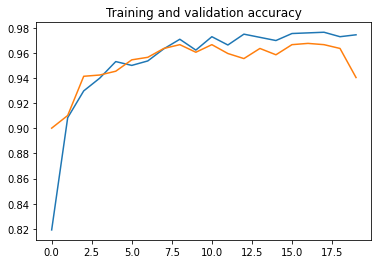

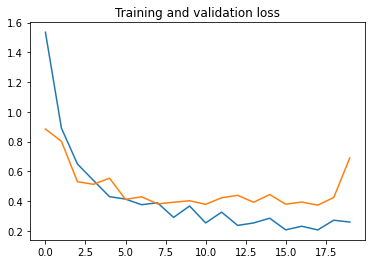

In [ ]:
# Retrieve a list of accuracy results on training and validation data
# sets for each training epoch
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

# Retrieve a list of list results on training and validation data
# sets for each training epoch
loss = history.history['loss']
val_loss = history.history['val_loss']

# Get number of epochs
epochs = range(len(acc))

# Plot training and validation accuracy per epoch
plt.plot(epochs, acc)
plt.plot(epochs, val_acc)
plt.title('Training and validation accuracy')

plt.figure()

# Plot training and validation loss per epoch
plt.plot(epochs, loss)
plt.plot(epochs, val_loss)
plt.title('Training and validation loss')

# **Previsões com o modelo implementado**

Carregando dataset de testes (OBS: carregar uma pasta com duas subpastas - "cats" e "dogs" - com suas respectivas imagens)

In [ ]:
#path e nome da pasta com o dataset
NAME_PASTA_ROOT = 'animals'

teste_datagen = ImageDataGenerator(rescale=1. / 255)

teste_generator = teste_datagen.flow_from_directory(
    NAME_PASTA_ROOT,
    target_size=(img_width, img_height),
    batch_size=32,
    #color_mode='grayscale',
    class_mode='binary')

Found 2 images belonging to 1 classes.


Caso o colab crie uma pasta de chekpoint oculta, e o generator reconheça como uma classe

In [ ]:
!cd animals&& rm -rf .ipynb_checkpoints 
!cd animals&& rm -rf dogs/.ipynb_checkpoints 
!cd animals&& rm -rf cats/.ipynb_checkpoints 

# Analisando imagens para os testes

In [ ]:
teste_cat_fnames = os.listdir(NAME_PASTA_ROOT+'/cats')
print(teste_cat_fnames)

teste_dog_fnames = os.listdir(NAME_PASTA_ROOT+'/dogs')
#train_dog_fnames.sort()
print(teste_dog_fnames)

FileNotFoundError: ignored

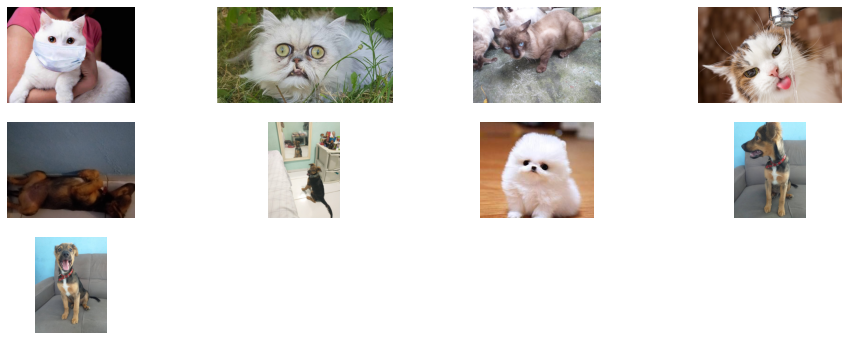

In [ ]:
# Parameters for our graph; we'll output images in a 4x4 configuration
nrows = 3
ncols = 4

# Index for iterating over images
pic_index = 0

# Set up matplotlib fig, and size it to fit 4x4 pics
fig = plt.gcf()
fig.set_size_inches(ncols * 4, nrows * 2)

pic_index += 6
next_cat_pix = [os.path.join(NAME_PASTA_ROOT+'/cats', fname) 
                for fname in teste_cat_fnames]
next_dog_pix = [os.path.join(NAME_PASTA_ROOT+'/dogs', fname) 
                for fname in teste_dog_fnames]

for i, img_path in enumerate(next_cat_pix+next_dog_pix):
  # Set up subplot; subplot indices start at 1
  sp = plt.subplot(nrows, ncols, i + 1)
  sp.axis('Off') # Don't show axes (or gridlines)

  img = mpimg.imread(img_path)
  plt.imshow(img)

plt.show()


# Clasificando imagens

Predizendo e classificando valor de entrada (x) do teste_generator

In [ ]:
X_val_sample, _ = next(teste_generator)
y_pred = model.predict(X_val_sample)

# **Plotando resultados finais**

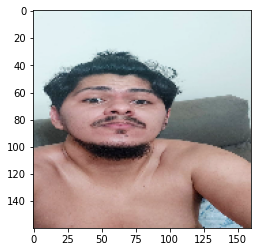

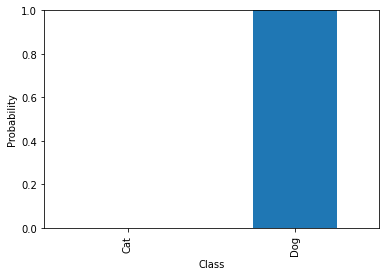

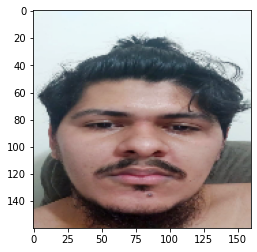

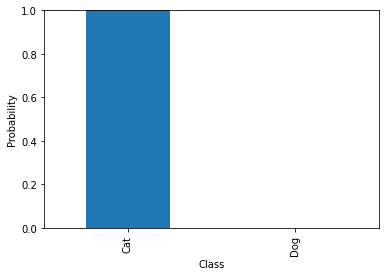

In [ ]:
for x, y in zip(X_val_sample, y_pred.flatten()):
      
    # plt.subplot(2,2,y)
    # plt.xticks([])
    # plt.yticks([])
    # plt.grid(False)
    img = array_to_img(x)
    plt.imshow(img, cmap=plt.cm.binary)
    plt.show()
    
    s = pd.Series({'Cat': 1-y, 'Dog': y})
    axes = s.plot(kind='bar')
    axes.set_xlabel('Class')
    axes.set_ylabel('Probability')
    axes.set_ylim([0, 1])
    plt.show()
    